In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

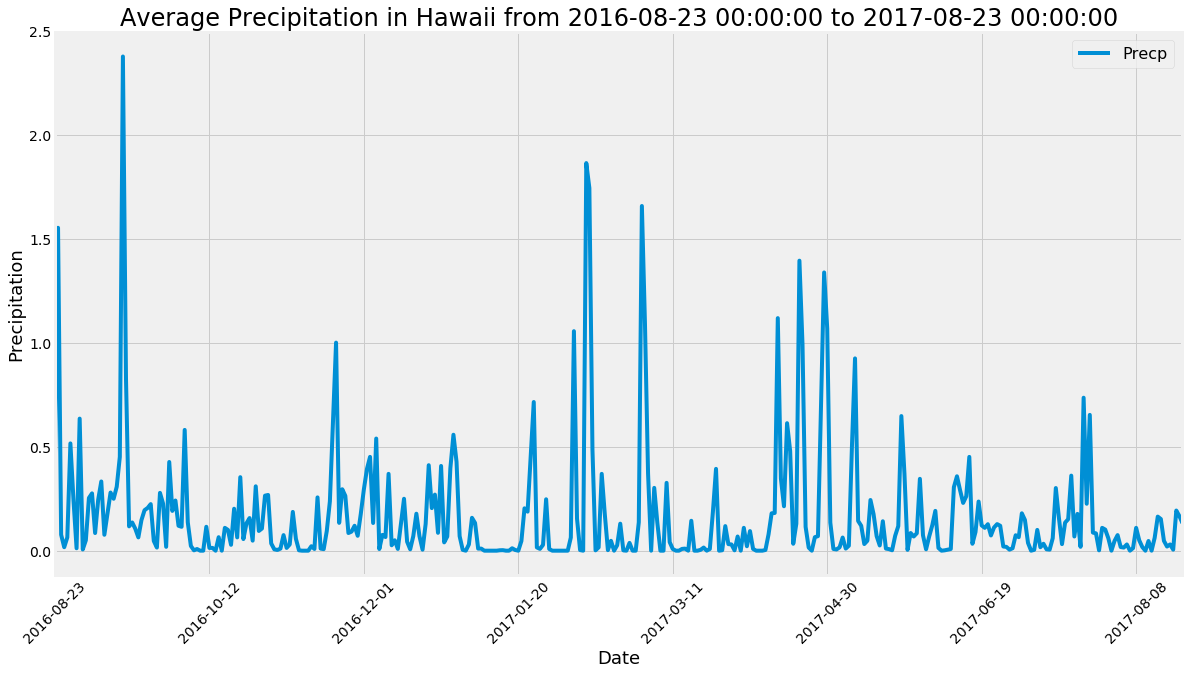

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the latest datapoint in the Database 


sel = [func.max(Measurement.date)]
Sel_Date = session.query(*sel)
Latest_Date = Sel_Date.first()
Fmt_Latest_Date = dt.datetime.strptime(Latest_Date[0], '%Y-%m-%d')


# Calculate the date 1 year ago from the last data point in the database
New_Date = Fmt_Latest_Date + relativedelta(years=-1)

# Perform a query to retrieve the data and precipitation scores
prcp_data =  session.query(Measurement.date, Measurement.prcp).\
             filter(Measurement.date >= New_Date.strftime('%Y-%m-%d')).\
             order_by((Measurement.date).asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data, columns=['date', 'Precp'])
prcp_data_df.set_index('date', inplace=True)

# Drop rows that have null values
prcp_data_df = prcp_data_df.dropna(how="any")


# Sort the dataframe by date
prcp_data_df=prcp_data_df.sort_values(by='date', ascending=True)
prcp_data_df.head()


# Use Pandas Plotting with Matplotlib to plot the data
Average_prcp_data_df=prcp_data_df.groupby(['date'])['Precp'].mean()   
Average_prcp_data_df.plot(figsize = (18, 10))
plt.title(f'Average Precipitation in Hawaii from {New_Date} to {Fmt_Latest_Date}',fontsize = 24)
plt.ylabel("Precipitation", fontsize = 18)
plt.xlabel("Date", fontsize = 18)
plt.xticks(fontsize=14, rotation = 45)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 16)
plt.savefig("Images\Average_Precipitation.png")
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()


,Precp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
Station_Count = session.query(func.count(Station.id)).scalar()
print(Station_Count)


9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

label1=func.count(Measurement.station).label('NewColumn')

Most_active_station = session.query(Measurement.station,label1 ).\
group_by(Measurement.station).order_by(label1.desc())
Most_active_station.all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

(station_max,pp2) = Most_active_station[0]
station_max

qry = session.query(func.min(Measurement.tobs).label("lowest_temperature"), 
                    func.max(Measurement.tobs).label("highest_temperature"),
                    func.avg(Measurement.tobs).label("average temperature")
                    ).filter(Measurement.station == station_max).all()
qry


[(54.0, 85.0, 71.66378066378067)]

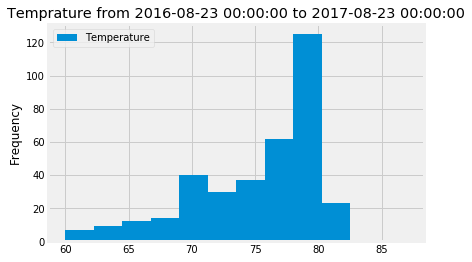

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Choose the station with the highest number of temperature observations.
station_activity_HStation = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .filter(Measurement.date >= New_Date.strftime('%Y-%m-%d'))\
    .order_by(func.count(Measurement.id).desc())\
    .first()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_activity_12m = session.query(Measurement.station,Measurement.tobs)\
    .filter(Measurement.date >= New_Date.strftime('%Y-%m-%d'))\
    .filter(Measurement.station == station_activity_HStation[0])\
    .group_by(Measurement.date)\
    .order_by((Measurement.date).asc()).all()


station_activity_12m_df = pd.DataFrame(station_activity_12m, columns=['Station', 'Temperature'])
station_activity_12m_df.set_index('Station', inplace=True)

station_activity_12m_df.plot.hist(by="Temperature", bins=12,title=(f'Temprature from {New_Date} to {Fmt_Latest_Date}' ))

plt.savefig("Images\Temperature-vs-Frequency.png")
plt.show() 

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps(New_Date, Fmt_Latest_Date))
derived_temp = (calc_temps(New_Date, Fmt_Latest_Date))



[(58.0, 74.57894736842105, 87.0)]


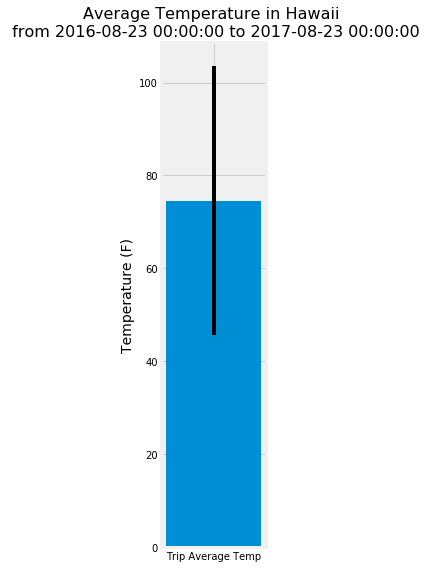

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_axis = ["Trip Average Temp"]
trip_avg = derived_temp[0][1]
error = derived_temp[0][2] - derived_temp[0][0]

plt.figure(figsize = (4,8))     
plt.bar(x_axis, trip_avg, yerr=error, align='center')
plt.title(f'Average Temperature in Hawaii \n from {New_Date} to {Fmt_Latest_Date}',fontsize = 16)
plt.ylabel("Temperature (F)", fontsize = 14)
plt.tight_layout()
plt.savefig("Images\Average_Temperature.png")
plt.show()



In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


Total_rainfall = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
                               group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
                               filter(Station.station == Measurement.station).\
                               filter(Measurement.date.between(New_Date, Fmt_Latest_Date)).all()
                          
Total_rainfall

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
